In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lg-smart-quality/sample_submission.csv
/kaggle/input/lg-smart-quality/train.csv
/kaggle/input/lg-smart-quality/test.csv


## 01. Load library

In [2]:
# basic library
import numpy as np
import random
import os
import warnings

# preprocessing library
from sklearn.preprocessing import LabelEncoder

# vlisulaization library
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# options library
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',200) # 열 200개 보여주기
pd.set_option('display.max_rows',200) #행 200개 보여주기

# modling library
from sklearn.model_selection import StratifiedKFold # StratifiedKFold 
from catboost import CatBoostClassifier, CatBoostRegressor # catboost

# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

# Optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 02. Load Data

In [3]:
train = pd.read_csv('/kaggle/input/lg-smart-quality/train.csv')
test = pd.read_csv('/kaggle/input/lg-smart-quality/test.csv')
sub = pd.read_csv('/kaggle/input/lg-smart-quality/sample_submission.csv')

- Columns
    - Y_class : 제품 품질 상태(Target)
        - 0 : 적정 기준 미달 (부적합)
        - 1 : 적합
        - 2 : 적정 기준 초과 (부적합)
    - Y_Quality : 제품 품질 관련 정량적 수치
    - TIMESTAMP : 제품이 공정에 들어간 시각
    - LINE : 제품이 들어간 공정 LINE 종류('T050304','T050307','T100304','T010306','T010305')
    - PRODUCT_CODE : 제품의 CODE 번호('A_31', 'T_31', 'O_31')
    - X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

## 03. EDA

### 01. data 형태 확인

In [4]:
display(train,test)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,...,X_2776,X_2777,X_2778,X_2779,X_2780,X_2781,X_2782,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,290.0,290.0,290.0,37.4,32.0,25.0,22.518519,20.0,23.0,22.185185,21.0,24.0,22.444444,21.0,25.0,23.074074,21.0,24.0,22.296296,21.0,24.0,22.592593,21.0,25.0,22.925926,20.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,NaN,5.02,7.00,40.06,0.000331,0.000033,NaN,47.2,47.094444,47.0,39.0,32.722222,26.0,184.7,175.903333,164.9,201.2,191.800000,181.6,139.6,131.646667,115.4,209.0,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,290.0,290.0,290.0,34.0,33.0,28.0,26.550000,25.0,24.0,23.500000,23.0,24.0,22.450000,21.0,24.0,23.100000,22.0,25.0,24.000000,23.0,25.0,23.600000,22.0,26.0,25.050000,24.0,51.6,51.2,51.2,53.7,60.9,54.4,54.4,56.9,58.3,53.8,53.8,54.0,59.4,60.7,60.7,60.4,57.4,59.2,59.2,57.7,58.5,61.0,61.0,53.6,53.8,53.8,57.0,56.7,54.4,54.4,61.1,56.4,52.0,52.0,51.9,8.00,NaN,5.00,7.05,36.54,0.001150,0.000009,NaN,47.1,47.084906,47.0,34.0,30.849057,27.0,186.0,168.417241,151.2,194.9,188.755172,177.1,145.5,128.748276,119.7,198.0,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,290.0,290.0,290.0,37.1,31.6,25.0,23.148148,21.0,24.0,23.000000,22.0,25.0,23.185185,22.0,25.0,23.925926,22.0,24.0,23.111111,22.0,25.0,23.370370,22.0,26.0,23.962963,22.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,...,X_2776,X_2777,X_2778,X_2779,X_2780,X_2781,X_2782,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,469.6,474.4,461.0,0.0,0.0,247.5,248.0,247.2,250.0,526.0,537.0,521.0,0.19,0.19,0.19,155.0,155.0,155.0,155.0,185.0,185.0,185.0,185.0,155.0,155.0,155.0,155.0,0.075,2.0,67.2,68.9,67.5,79.8,70.9,80.5,71.2,67.0,76.4,76.0,68.6,79.2,77.9,67.9,79.4,80.9,69.4,77.2,73.7,66.0,70.3,79.4,74.9,76.9,66.4,67.6,67.5,0.5,82.5,1.0,0.0,2.0,2.0,10.12,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,129.0,129.0,129.0,130.0,36.0,999.0,NaN,0.19,0.19,0.19,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,506.6,511.1,500.1,0.0,0.0,247.6,248.2,247.4,250.0,489.0,496.0,484.0,0.19,0.19,0.19,155.0,155.0,155.0,155.0,185.0,185.0,185.0,185.0,155.0,155.0,155.0,155.0,0.079,2.0,63.7,64.6,64.7,78.6,69.0,82.2,70.4,64.7,74.3,76.4,66.1,79.5,76.9,64.8,77.7,79.7,66.5,75.1,75.0,64.3,70.0,78.3,69.6,73.7,64.6,64.3,64.3,0.5,82.5,1.0,0.0,2.0,2.0,10.22,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,130.0,130.0,130.0,130.0,35.0,999.0,28.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,506.6,511.4,500.6,0.0,0.0,247.6,247.9,247.4,250.0,488.0,496.0,484.0,0.19,0.19,0.19,155.0,155.0,155.0,155.0,185.0,185.0,185.0,185.0,155.0,155.0,155.0,155.0,0.079,2.0,63.7,64.6,64.7,78.6,69.0,82.2,70.4,64.7,74.3,76.4,66.1,79.5,76.9,64.8,77.7,79.7,66.5,75.1,75.0,64.3,70.0,78.3,69.6,73.7,64.6,64.3,64.3,0.5,82.5,1.0,0.0,2.0,2.0,10.22,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,130.0,130.0,130.0,130.0,35.0,999.0,28.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_0

In [5]:
set1 = set(train.columns)
set2 = set(test.columns)
print(len(set1 & set2))

2879


In [6]:
set1.difference(set2)

{'Y_Class', 'Y_Quality'}

- Y_Class, Y_Quality를 제외한 나머지 컬럼은 train, test 모두 동일하다는 것을 알 수 있음.

In [7]:
train.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PRODUCT_ID    598 non-null    object 
 1   Y_Class       598 non-null    int64  
 2   Y_Quality     598 non-null    float64
 3   TIMESTAMP     598 non-null    object 
 4   LINE          598 non-null    object 
 5   PRODUCT_CODE  598 non-null    object 
 6   X_1           349 non-null    float64
 7   X_2           349 non-null    float64
 8   X_3           349 non-null    float64
 9   X_4           349 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 46.8+ KB


- TIMESTAMP가 시간의 형태가 아닌 숫자형 확인
- X_1부터 X_2895는 모두 숫자형으로 확인

### 02. Target 분포

Text(0.5, 1.0, 'Y_Class Countplot')

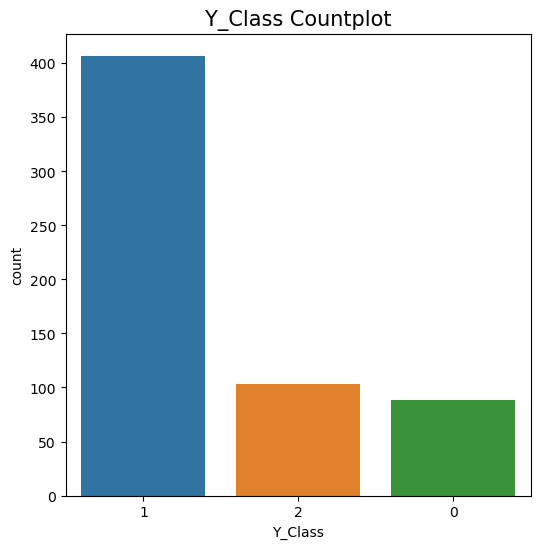

In [8]:
plt.figure(figsize=(6,6))
sns.countplot(x='Y_Class',data=train,order=train['Y_Class'].value_counts().index)
plt.xlabel('Y_Class',fontsize=10)
plt.title('Y_Class Countplot',fontsize=15)

- Class 1(정상) : 407개
- Class 2(비정상) : 103개
- Class 3(비정상) : 88개
- 정상 Class가 많지만 Class가 약간의 불균형이 존재함.

### 03. 정량적 지표인 Y_Quality 분포 확인

Text(0.5, 1.0, 'Y_Quality distribution')

<Figure size 1000x1000 with 0 Axes>

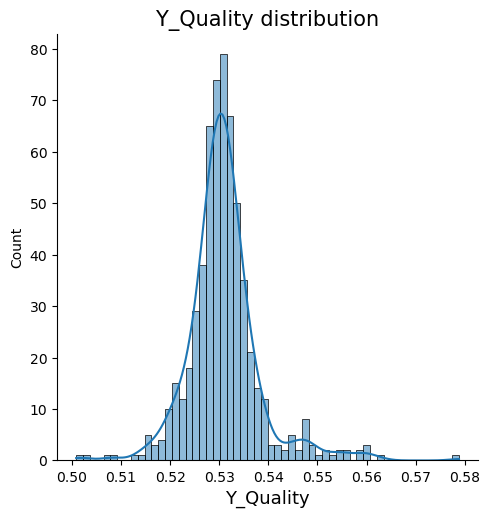

In [9]:
plt.figure(figsize=(10,10))
sns.displot(data=train,x='Y_Quality',kde=True)
plt.xlabel('Y_Quality',fontsize=13)
plt.title('Y_Quality distribution',fontsize=15)

In [10]:
train.groupby(['Y_Class'])['Y_Quality'].describe()

,count,mean,std,min,25%,50%,75%,max
Y_Class,,,,,,,,
0,88.0,0.520837,0.004603,0.500856,0.519440,0.522054,0.524113,0.525067
1,407.0,0.530253,0.002444,0.525086,0.528378,0.530308,0.532129,0.534843
2,103.0,0.542031,0.008038,0.534951,0.536354,0.538508,0.546555,0.578841


- Target의 정량적 지표인 Y_Quality값을 확인해보면, 값의 대부분이 0.53 근처에 존재함과 동시에 정규분포의 형태가 나타남
- 그리고 Class마다 Spec이 다르다는 것을 알 수가 있었음.

- Spec
    - Class 0 : (0.500856, 0.525067)
    - Class 1 : (0.525086, 0.534843)
    - Class 2 : (0.534951, 0.578841)
    
    
- 추후에 Classification 뿐만 아니라 Regression으로 모델링한다면 값을 통해 Class 변경을 할 수 있을 것이라 판단이 된다.

### 04. 파생변수 생성

In [11]:
# 요일
# train['weekday'] = train['TIMESTAMP'].dt.weekday
# test['weekday'] = test['TIMESTAMP'].dt.weekday
# 오전과 오후
# train['is_afternoon'] = (train['TIMESTAMP'].dt.hour>12).astype('int')
# test['is_afternoon'] = (test['TIMESTAMP'].dt.hour>12).astype('int')

def derived_variable_procedure(data):
    
    # TIMESTAMP 시간 형태로 변경
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
    
    # TIME이라는 변수는 모두 분 단위로 시간 변경
    # 이유 : 기본적으로 100개씩 봤을 때, 분포가 달라졌음. 그래서 분 단위의 시간으로 변경해서 진행
    data['TIME'] = data['TIMESTAMP'].dt.month*60*24*30+data['TIMESTAMP'].dt.day*60*24+data['TIMESTAMP'].dt.hour*60+data['TIMESTAMP'].dt.minute
    
    # LINE 별 데이터 분포의 차이가 크게 났기 때문이고, 
    # 04,06만 제품 O,T 존재.
    # LINE 별 T 제외 첫 자 추출
    data['LINE_first'] = data['LINE'].str[1:3]
    
    # LINE 별 마지막 2글자 추출
    data['LINE_Last'] = data['LINE'].str[5:]

    # LINE, PRODUCT_CODE 별 데이터 묶은 후 Class 값이 매우 다름.
    data['LP'] = data['LINE']+'-'+data['PRODUCT_CODE']
    
    # 시간 별 분포차이가 크기 때문에 추출
    data['hour'] = data['TIMESTAMP'].dt.hour
    
    # 일자 별 분포차이가 크기 때문에 추출
    data['day'] = data['TIMESTAMP'].dt.day
    
    # 일자 별 분포차이가 크기 때문에 추출
    data['minute'] = data['TIMESTAMP'].dt.minute
    
    return data

In [12]:
train = derived_variable_procedure(train)
test = derived_variable_procedure(test)

In [13]:
display(train,test)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,...,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,TIME,LINE_first,LINE_Last,LP,hour,day,minute
0,TRAIN_000,1,0.533433,2022-06-13 05:14:00,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,23.0,22.185185,21.0,24.0,22.444444,21.0,25.0,23.074074,21.0,24.0,22.296296,21.0,24.0,22.592593,21.0,25.0,22.925926,20.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,NaN,5.02,7.00,40.06,0.000331,0.000033,NaN,47.2,47.094444,47.0,39.0,32.722222,26.0,184.7,175.903333,164.9,201.2,191.800000,181.6,139.6,131.646667,115.4,209.0,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN,278234,05,04,T050304-A_31,5,13,14
1,TRAIN_001,2,0.541819,2022-06-13 05:22:00,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,24.0,23.500000,23.0,24.0,22.450000,21.0,24.0,23.100000,22.0,25.0,24.000000,23.0,25.0,23.600000,22.0,26.0,25.050000,24.0,51.6,51.2,51.2,53.7,60.9,54.4,54.4,56.9,58.3,53.8,53.8,54.0,59.4,60.7,60.7,60.4,57.4,59.2,59.2,57.7,58.5,61.0,61.0,53.6,53.8,53.8,57.0,56.7,54.4,54.4,61.1,56.4,52.0,52.0,51.9,8.00,NaN,5.00,7.05,36.54,0.001150,0.000009,NaN,47.1,47.084906,47.0,34.0,30.849057,27.0,186.0,168.417241,151.2,194.9,188.755172,177.1,145.5,128.748276,119.7,198.0,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN,278242,05,07,T050307-A_31,5,13,22
2,TRAIN_002,1,0.531267,2022-06-13 05:30:00,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,24.0,23.000000,22.0,25.0,23.185185,22.0,25.0,23.925926,22.0,24.0,23.111111,22.0,25.0,23.370370,22.0,26.0,23.962963,22.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,...,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,TIME,LINE_first,LINE_Last,LP,hour,day,minute
0,TEST_000,2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,469.6,474.4,461.0,0.0,0.0,247.5,248.0,247.2,250.0,526.0,537.0,521.0,0.19,0.19,0.19,155.0,155.0,155.0,155.0,185.0,185.0,185.0,185.0,155.0,155.0,155.0,155.0,0.075,2.0,67.2,68.9,67.5,79.8,70.9,80.5,71.2,67.0,76.4,76.0,68.6,79.2,77.9,67.9,79.4,80.9,69.4,77.2,73.7,66.0,70.3,79.4,74.9,76.9,66.4,67.6,67.5,0.5,82.5,1.0,0.0,2.0,2.0,10.12,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,129.0,129.0,129.0,130.0,36.0,999.0,NaN,0.19,0.19,0.19,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401881,10,06,T100306-T_31,2,9,1
1,TEST_001,2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,506.6,511.1,500.1,0.0,0.0,247.6,248.2,247.4,250.0,489.0,496.0,484.0,0.19,0.19,0.19,155.0,155.0,155.0,155.0,185.0,185.0,185.0,185.0,155.0,155.0,155.0,155.0,0.079,2.0,63.7,64.6,64.7,78.6,69.0,82.2,70.4,64.7,74.3,76.4,66.1,79.5,76.9,64.8,77.7,79.7,66.5,75.1,75.0,64.3,70.0,78.3,69.6,73.7,64.6,64.3,64.3,0.5,82.5,1.0,0.0,2.0,2.0,10.22,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,130.0,130.0,130.0,130.0,35.0,999.0,28.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401889,10,04,T100304-T_31,2,9,9
2,TEST_002,2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,506.6,511.4,500.6,0.0,0.0,247.6,247.9,247.4,250.0,488.0,496.0,484.0,0.19,0.19,0.19,155.0,155.0,155.0,155.0,185.0,185.0,185.0,185.0,155.0,155.0,155.0,155.0,0.079,2.0,63.7,64.6,64.7,78.6,69.0,82.2,70.4,64.7,74.3,76.4,66.1,79.5,76.9,64.8,77.7,79.7,66.5,75.1,75.0,64.3,70.0,78.3,69.6,73.7,64.6,64.3,64.3,0.5,82.5,1.0,0.0,2.0,2.0,10.22,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,130.0,130.0,130.0,130.0,35.0,999.0,28.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402282,10,04,T100304

### 05. minute 분포

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 

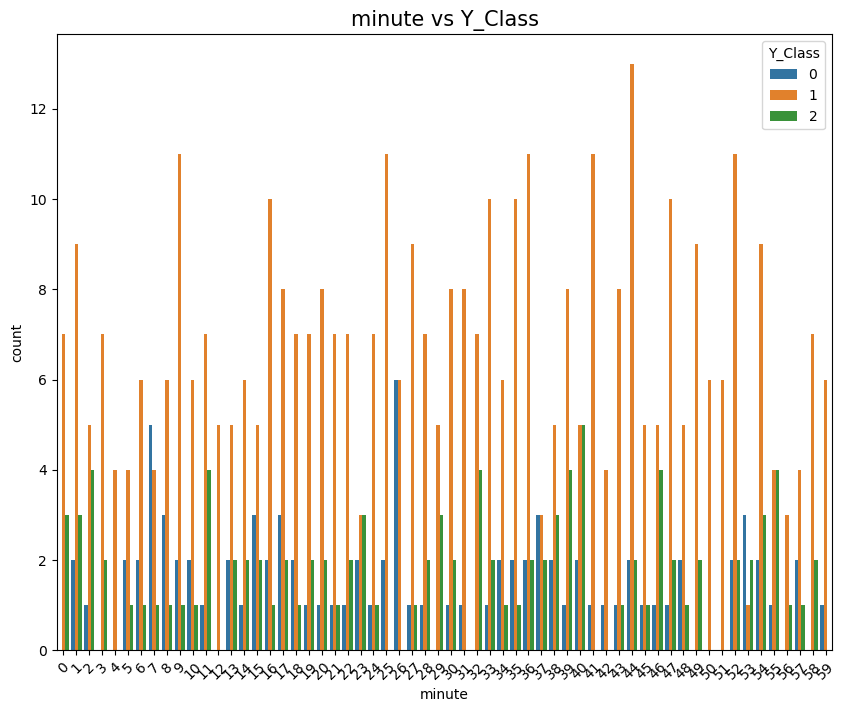

In [14]:
plt.figure(figsize=(10,8))
sns.countplot(x='minute',hue='Y_Class',data=train)
plt.xlabel('minute',fontsize=10)
plt.title('minute vs Y_Class',fontsize=15)
plt.xticks(rotation=45)

- minute 단위 별로 Class 간의 차이가 보이는 것을 확인할 수 있음

### 06. Day

Text(0.5, 1.0, 'day vs Y_Class')

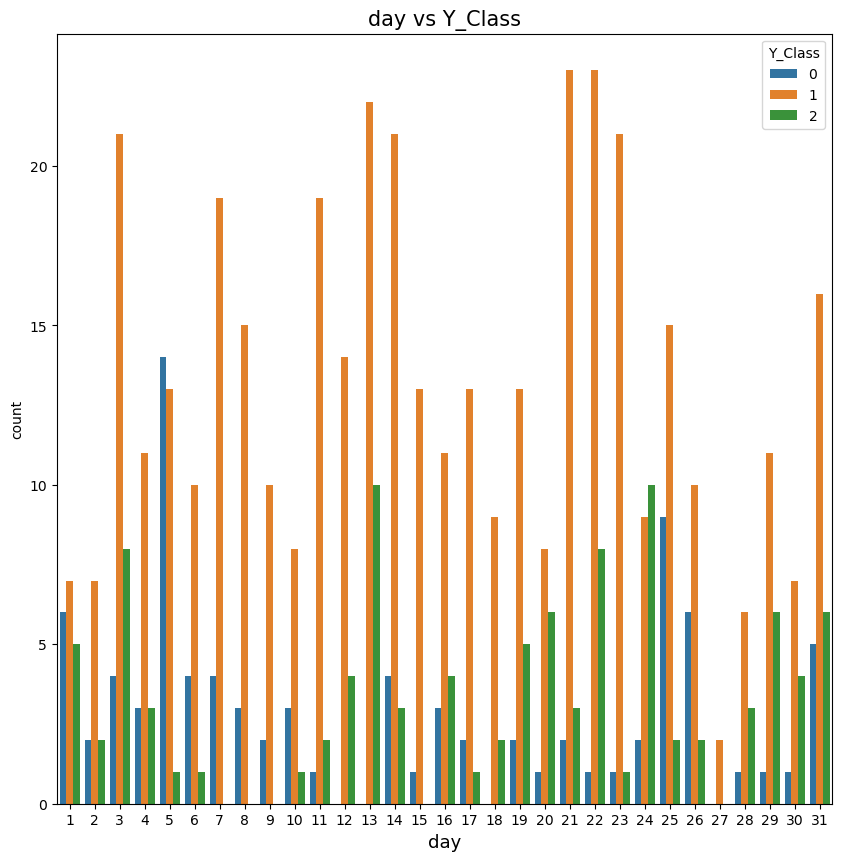

In [15]:
plt.figure(figsize=(10,10))
sns.countplot(x='day',hue='Y_Class',data=train)
plt.xlabel('day',fontsize=13)
plt.title('day vs Y_Class',fontsize=15)

- Day 단위 별로 Class 간의 차이가 보이는 것을 확인할 수 있음

### 07. hour

Text(0.5, 1.0, 'hour vs Y_Class')

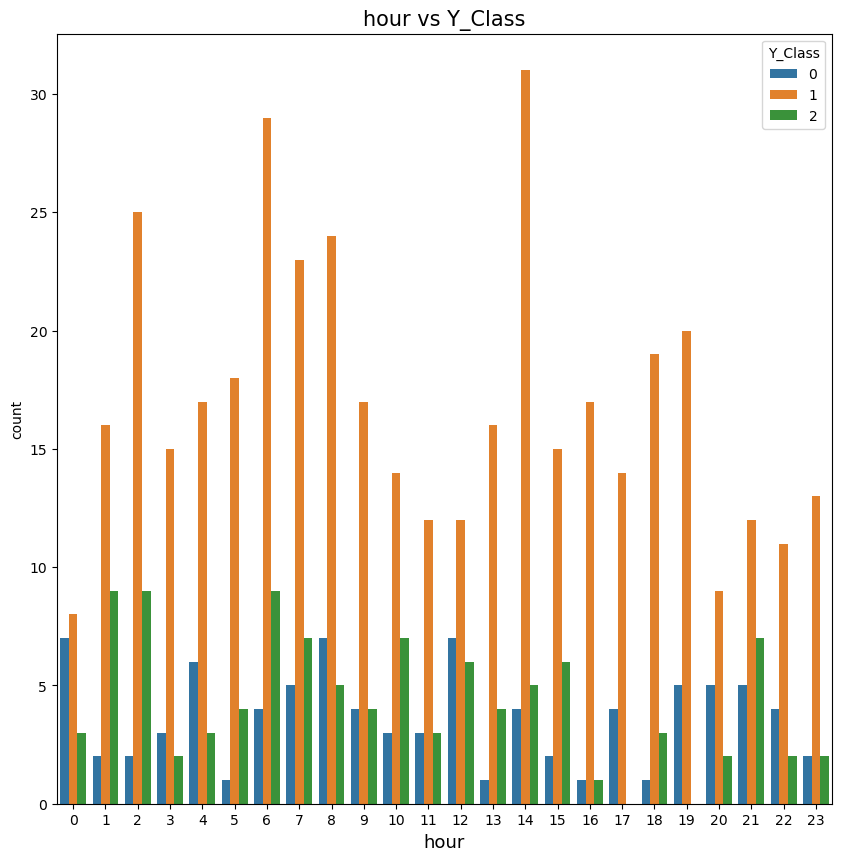

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x='hour',hue='Y_Class',data=train)
plt.xlabel('hour',fontsize=13)
plt.title('hour vs Y_Class',fontsize=15)

- hour 단위 별로 Class 간의 차이가 보이는 것을 확인할 수 있음

### 08. LP(LINE-PRODUCT_CODE)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'T050304-A_31'),
  Text(1, 0, 'T050307-A_31'),
  Text(2, 0, 'T100304-T_31'),
  Text(3, 0, 'T100306-T_31'),
  Text(4, 0, 'T010306-A_31'),
  Text(5, 0, 'T010305-A_31'),
  Text(6, 0, 'T100304-O_31'),
  Text(7, 0, 'T100306-O_31')])

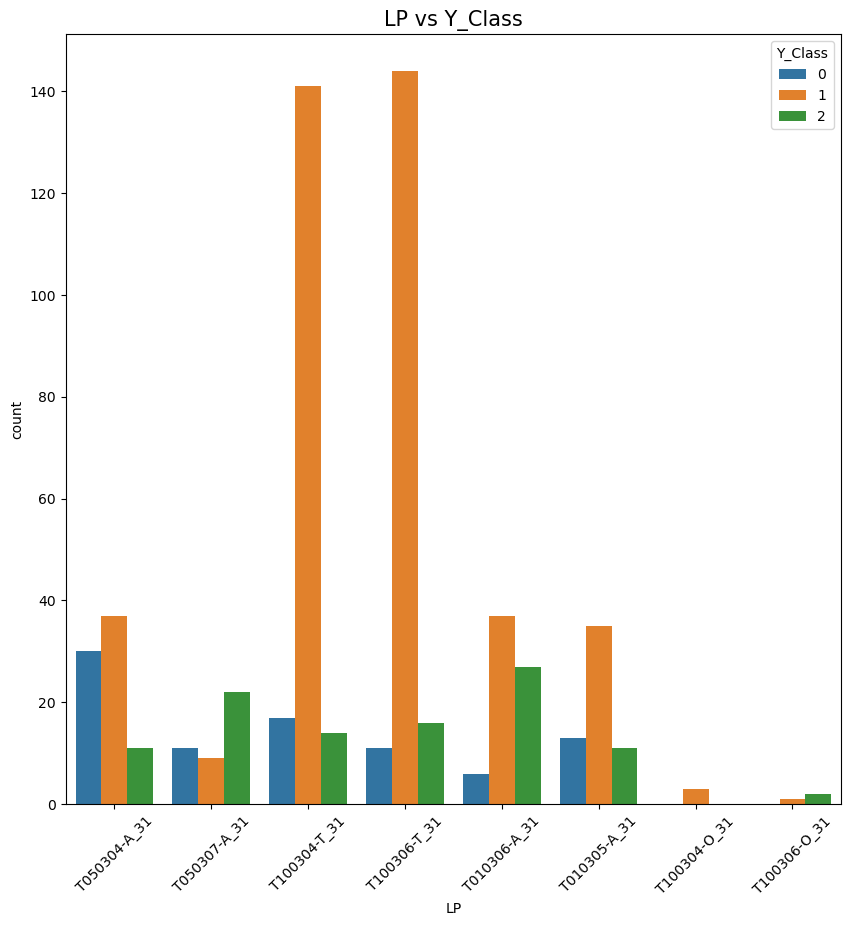

In [17]:
plt.figure(figsize=(10,10))
sns.countplot(x='LP',hue='Y_Class',data=train)
plt.xlabel('LP',fontsize=10)
plt.title('LP vs Y_Class',fontsize=15)
plt.xticks(rotation=45)

- LP(LINE-PRODUCT_CODE) 단위 별로 Class 간의 차이가 보이는 것을 확인할 수 있음
- T를 제외한 첫 2개의 숫자 중 10은 제품 T와 O를 만들었음. 또한, 05,01은 A만 만드는 것을 알 수 있게 되어서 LINE_FIRST라는 변수를 생성함.

## 04. Modeling

### 01. 데이터 묶기

In [18]:
all_data = pd.concat([train,test])
all_data.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,...,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,TIME,LINE_first,LINE_Last,LP,hour,day,minute
0,TRAIN_000,1.0,0.533433,2022-06-13 05:14:00,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,23.0,22.185185,21.0,24.0,22.444444,21.0,25.0,23.074074,21.0,24.0,22.296296,21.0,24.0,22.592593,21.0,25.0,22.925926,20.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,NaN,5.02,7.00,40.06,0.000331,0.000033,NaN,47.2,47.094444,47.0,39.0,32.722222,26.0,184.7,175.903333,164.9,201.2,191.800000,181.6,139.6,131.646667,115.4,209.0,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN,278234,05,04,T050304-A_31,5,13,14
1,TRAIN_001,2.0,0.541819,2022-06-13 05:22:00,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,24.0,23.500000,23.0,24.0,22.450000,21.0,24.0,23.100000,22.0,25.0,24.000000,23.0,25.0,23.600000,22.0,26.0,25.050000,24.0,51.6,51.2,51.2,53.7,60.9,54.4,54.4,56.9,58.3,53.8,53.8,54.0,59.4,60.7,60.7,60.4,57.4,59.2,59.2,57.7,58.5,61.0,61.0,53.6,53.8,53.8,57.0,56.7,54.4,54.4,61.1,56.4,52.0,52.0,51.9,8.00,NaN,5.00,7.05,36.54,0.001150,0.000009,NaN,47.1,47.084906,47.0,34.0,30.849057,27.0,186.0,168.417241,151.2,194.9,188.755172,177.1,145.5,128.748276,119.7,198.0,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN,278242,05,07,T050307-A_31,5,13,22
2,TRAIN_002,1.0,0.531267,2022-06-13 05:30:00,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,24.0,23.000000,22.0,25.0,23.185185,22.0,25.0,23.925926,22.0,24.0,23.111111,22.0,25.0,23.370370,22.0,26.0,23.962963,22.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,

### 02. 결측치 처리

In [19]:
all_data = all_data.fillna(0)

# 다양한 실험 중 0이 가장 결과가 좋았음.

### 03. target, timestamp, 필요없는 변수 제거

In [20]:
all_data2 = all_data.drop(['PRODUCT_ID','TIMESTAMP','Y_Class','Y_Quality'],axis=1)
all_data2.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,...,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,TIME,LINE_first,LINE_Last,LP,hour,day,minute
0,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,23.0,22.185185,21.0,24.0,22.444444,21.0,25.0,23.074074,21.0,24.0,22.296296,21.0,24.0,22.592593,21.0,25.0,22.925926,20.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,0.0,5.02,7.00,40.06,0.000331,0.000033,0.0,47.2,47.094444,47.0,39.0,32.722222,26.0,184.7,175.903333,164.9,201.2,191.800000,181.6,139.6,131.646667,115.4,209.0,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0,278234,05,04,T050304-A_31,5,13,14
1,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,24.0,23.500000,23.0,24.0,22.450000,21.0,24.0,23.100000,22.0,25.0,24.000000,23.0,25.0,23.600000,22.0,26.0,25.050000,24.0,51.6,51.2,51.2,53.7,60.9,54.4,54.4,56.9,58.3,53.8,53.8,54.0,59.4,60.7,60.7,60.4,57.4,59.2,59.2,57.7,58.5,61.0,61.0,53.6,53.8,53.8,57.0,56.7,54.4,54.4,61.1,56.4,52.0,52.0,51.9,8.00,0.0,5.00,7.05,36.54,0.001150,0.000009,0.0,47.1,47.084906,47.0,34.0,30.849057,27.0,186.0,168.417241,151.2,194.9,188.755172,177.1,145.5,128.748276,119.7,198.0,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0,278242,05,07,T050307-A_31,5,13,22
2,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,24.0,23.000000,22.0,25.0,23.185185,22.0,25.0,23.925926,22.0,24.0,23.111111,22.0,25.0,23.370370,22.0,26.0,23.962963,22.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,0.0,5.02,6.52,40.05,0.000332,0.000033,0.0,47.2,47.088679,47.0,35.0,30.603774,27.0,181.4,17

### 04. train2, test2 만들기 

In [21]:
train2 = all_data2[:len(train)]
test2 = all_data2[len(train):]

### 05. Label Encoding

In [22]:
qual_col = ['LINE', 'PRODUCT_CODE','LP']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train2[i])
    train2[i] = le.transform(train2[i])
    
    for label in np.unique(test2[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test2[i] = le.transform(test2[i]) 
print('Done.')

Done.


In [23]:
train2.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,...,X_2783,X_2784,X_2785,X_2786,X_2787,X_2788,X_2789,X_2790,X_2791,X_2792,X_2793,X_2794,X_2795,X_2796,X_2797,X_2798,X_2799,X_2800,X_2801,X_2802,X_2803,X_2804,X_2805,X_2806,X_2807,X_2808,X_2809,X_2810,X_2811,X_2812,X_2813,X_2814,X_2815,X_2816,X_2817,X_2818,X_2819,X_2820,X_2821,X_2822,X_2823,X_2824,X_2825,X_2826,X_2827,X_2828,X_2829,X_2830,X_2831,X_2832,X_2833,X_2834,X_2835,X_2836,X_2837,X_2838,X_2839,X_2840,X_2841,X_2842,X_2843,X_2844,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2851,X_2852,X_2853,X_2854,X_2855,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,TIME,LINE_first,LINE_Last,LP,hour,day,minute
0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,23.0,22.185185,21.0,24.0,22.444444,21.0,25.0,23.074074,21.0,24.0,22.296296,21.0,24.0,22.592593,21.0,25.0,22.925926,20.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,0.0,5.02,7.00,40.06,0.000331,0.000033,0.0,47.2,47.094444,47.0,39.0,32.722222,26.0,184.7,175.903333,164.9,201.2,191.800000,181.6,139.6,131.646667,115.4,209.0,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0,278234,05,04,2,5,13,14
1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,24.0,23.500000,23.0,24.0,22.450000,21.0,24.0,23.100000,22.0,25.0,24.000000,23.0,25.0,23.600000,22.0,26.0,25.050000,24.0,51.6,51.2,51.2,53.7,60.9,54.4,54.4,56.9,58.3,53.8,53.8,54.0,59.4,60.7,60.7,60.4,57.4,59.2,59.2,57.7,58.5,61.0,61.0,53.6,53.8,53.8,57.0,56.7,54.4,54.4,61.1,56.4,52.0,52.0,51.9,8.00,0.0,5.00,7.05,36.54,0.001150,0.000009,0.0,47.1,47.084906,47.0,34.0,30.849057,27.0,186.0,168.417241,151.2,194.9,188.755172,177.1,145.5,128.748276,119.7,198.0,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0,278242,05,07,3,5,13,22
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,24.0,23.000000,22.0,25.0,23.185185,22.0,25.0,23.925926,22.0,24.0,23.111111,22.0,25.0,23.370370,22.0,26.0,23.962963,22.0,49.7,50.9,50.9,51.8,59.4,52.6,52.6,54.9,53.2,51.4,51.4,51.1,48.9,55.5,55.5,52.5,47.3,55.2,55.2,48.8,49.6,55.2,55.2,50.2,52.6,52.6,52.0,53.2,52.3,52.3,58.7,55.4,50.5,50.5,50.1,9.04,0.0,5.02,6.52,40.05,0.000332,0.000033,0.0,47.2,47.088679,47.0,35.0,30.603774,27.0,181.4,176.137931,167.4,194.5,187.310345,183.6,128.0,115.3

- LINE, PRODUCT_CODE는 train, test가 모두 동일한 종류라는 데이터 규칙 정보에 의해서 같이 해도 상관없음

### 06. Regression 모델링

#### Y_Quality로 Regression 모델링을 진행한 후에 Classification과 비교하고, Spec을 많이 벗어나는 경우면 Class 변경하기 위함

#### 최적 하이퍼파라미터는 Optuna로 구함

#### 06-1 train/test split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(train2, train['Y_Quality'], test_size = 0.2, shuffle = True,random_state = 42)

In [25]:
# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1000, 20000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                           verbose=0, early_stopping_rounds=25)
                           
    # 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    MSE = mean_squared_error(y_val, model_cbrm.predict(X_val))
    return MSE

optuna_cbrm = optuna.create_study(direction='minimize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials = 50)

[I 2023-03-06 13:03:18,143] A new study created in memory with name: no-name-40aa156e-0f67-4f6c-80ce-c2b6b9d94cef
[I 2023-03-06 13:03:22,484] Trial 0 finished with value: 3.732254544857415e-05 and parameters: {'iterations': 15655, 'od_wait': 537, 'learning_rate': 0.6373117525770127, 'reg_lambda': 74.88039076582236, 'subsample': 0.4985070123025904, 'random_strength': 18.991865821233908, 'depth': 3, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.022561047334047252, 'colsample_bylevel': 0.8112158910206784}. Best is trial 0 with value: 3.732254544857415e-05.
[I 2023-03-06 13:03:30,955] Trial 1 finished with value: 4.329739119085064e-05 and parameters: {'iterations': 19115, 'od_wait': 507, 'learning_rate': 0.5170703407519188, 'reg_lambda': 81.26209803900173, 'subsample': 0.6125260668293881, 'random_strength': 38.87021269727198, 'depth': 5, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 11, 'bagging_temperature': 1.4797129411694714, 'colsample_byleve

#### 06-2 최적 hyperparamter

In [26]:
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

Best Trial: score 2.688906870209248e-05,
params {'iterations': 9053, 'od_wait': 2151, 'learning_rate': 0.6056051072423216, 'reg_lambda': 17.049884379872957, 'subsample': 0.4842579689515585, 'random_strength': 19.836064597418982, 'depth': 2, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.12870445020851518, 'colsample_bylevel': 0.6521536263076307}


#### 06-3 CatBoostRegressor
- Class의 비율이 다르기 때문에 StratifiedKFold
- 10-fold Cross-validation 진행(모델의 안정성을 위함)

In [27]:
cbc = CatBoostRegressor(**cbrm_trial_params, verbose=100)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

result_quality = 0
best_score = 0
feature_importance_quality = 0

for train_idx,valid_idx in skf.split(train2,train['Y_Class']):
    
    x_train = train2.iloc[train_idx]
    x_valid = train2.iloc[valid_idx]
    
    y_train = train['Y_Quality'].iloc[train_idx]
    y_valid = train['Y_Quality'].iloc[valid_idx]
        
    cbc.fit(x_train,y_train,eval_set=(x_valid,y_valid),early_stopping_rounds=100)
    result_quality += cbc.predict(test2)/10
    feature_importance_quality += cbc.feature_importances_/10 # 학습할 때 변수중요도 저장됨.

0:	learn: 0.0074796	test: 0.0065832	best: 0.0065832 (0)	total: 17.6ms	remaining: 2m 39s
100:	learn: 0.0017558	test: 0.0037003	best: 0.0037003 (100)	total: 1.84s	remaining: 2m 42s
200:	learn: 0.0008343	test: 0.0036249	best: 0.0036011 (165)	total: 3.75s	remaining: 2m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.003601070787
bestIteration = 165

Shrink model to first 166 iterations.
0:	learn: 0.0069981	test: 0.0088750	best: 0.0088750 (0)	total: 18ms	remaining: 2m 43s
100:	learn: 0.0018279	test: 0.0048499	best: 0.0047411 (58)	total: 1.81s	remaining: 2m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.004741087586
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 0.0074531	test: 0.0068336	best: 0.0068336 (0)	total: 17.6ms	remaining: 2m 39s
100:	learn: 0.0017129	test: 0.0044304	best: 0.0042944 (43)	total: 1.87s	remaining: 2m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.004294447535
bestIteration 

#### 06-4 CatBoostClassifier
- Y_Class를 활용해 Classification 진행
- 이번 Phase2에서는 optuna+CatBoostClassifier가 시간이 엄청 오래 걸려서 optuna 진행 X

In [28]:
cbc = CatBoostClassifier(verbose=100,iterations=1000,task_type='GPU')

skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=100)
# 데이터의 개수는 적은데 정답 클래스의 종류는 3개로 많음. 
# n_splits를 크게 해서 최대한 다양한 클래스를 학습하게 하는 것이 좋음.

result_cbc = 0
best_score = 0
feature_importance = 0

for train_idx,valid_idx in skf.split(train2,train['Y_Class']):
    
    x_train = train2.iloc[train_idx]
    x_valid = train2.iloc[valid_idx]
    
    y_train = train['Y_Class'].iloc[train_idx]
    y_valid = train['Y_Class'].iloc[valid_idx]    
    cbc.fit(x_train,y_train,eval_set=(x_valid,y_valid),early_stopping_rounds=100)
    result_cbc += cbc.predict_proba(test2)/10
    best_score += cbc.best_score_['validation']['MultiClass']/10
    feature_importance += cbc.feature_importances_/10 # 학습할 때 변수중요도 저장됨.

Learning rate set to 0.098773
0:	learn: 1.0250172	test: 1.0289143	best: 1.0289143 (0)	total: 28ms	remaining: 28s
100:	learn: 0.3330064	test: 0.6219264	best: 0.6219264 (100)	total: 1.88s	remaining: 16.7s
200:	learn: 0.2040535	test: 0.6041482	best: 0.6037767 (199)	total: 3.72s	remaining: 14.8s
300:	learn: 0.1405134	test: 0.5937099	best: 0.5874324 (251)	total: 5.69s	remaining: 13.2s
400:	learn: 0.1015090	test: 0.5809771	best: 0.5795102 (389)	total: 7.92s	remaining: 11.8s
500:	learn: 0.0770306	test: 0.5801336	best: 0.5780734 (413)	total: 9.82s	remaining: 9.78s
bestTest = 0.5780733744
bestIteration = 413
Shrink model to first 414 iterations.
Learning rate set to 0.098773
0:	learn: 1.0266929	test: 1.0339564	best: 1.0339564 (0)	total: 23.7ms	remaining: 23.7s
100:	learn: 0.3180132	test: 0.5592421	best: 0.5587425 (99)	total: 1.81s	remaining: 16.1s
200:	learn: 0.1959527	test: 0.5475932	best: 0.5459630 (197)	total: 3.69s	remaining: 14.7s
300:	learn: 0.1351636	test: 0.5307987	best: 0.5307987 (300)

## 07. regression vs classification

In [29]:
# Class 0 Spec
train[train['Y_Class']==0]['Y_Quality'].max(),train[train['Y_Class']==1]['Y_Quality'].min()

(0.525066667, 0.525085714)

In [30]:
# Class 1 Spec
train[train['Y_Class']==1]['Y_Quality'].max(),train[train['Y_Class']==2]['Y_Quality'].min()

(0.534842857, 0.534950794)

In [31]:
## regression vs classification
result_df = pd.DataFrame(result_cbc,columns=['0_class','1_class','2_class'])
result_df['quality'] = result_quality
result_df['quality_label'] = result_df['quality'].apply(lambda x: 0 if x <0.525085714 else 2 if x>0.534950794 else 1)
result_df['class_label'] = result_cbc.argmax(1)
result_df

,0_class,1_class,2_class,quality,quality_label,class_label
0,0.053984,0.899270,0.046746,0.528928,1,1
1,0.110848,0.516942,0.372210,0.533931,1,1
2,0.061501,0.761178,0.177320,0.533435,1,1
3,0.253178,0.685420,0.061403,0.523752,0,1
4,0.219172,0.605608,0.175220,0.529771,1,1
...,...,...,...,...,...,...
305,0.134588,0.778170,0.087243,0.526709,1,1
306,0.127126,0.803908,0.068966,0.523232,0,1
307,0.114875,0.799486,0.085639,0.525901,1,1
308,0.140838,0.774158,0.085004,0.526261,1,1


In [32]:
## 두 개의 label이 다른 것 추출
result_df = pd.DataFrame(result_cbc,columns=['0_class','1_class','2_class'])
result_df['quality'] = result_quality
result_df['quality_label'] = result_df['quality'].apply(lambda x: 0 if x <0.525085714 else 2 if x>0.534950794 else 1)
result_df['class_label'] = result_cbc.argmax(1)
result_df

,0_class,1_class,2_class,quality,quality_label,class_label
0,0.053984,0.899270,0.046746,0.528928,1,1
1,0.110848,0.516942,0.372210,0.533931,1,1
2,0.061501,0.761178,0.177320,0.533435,1,1
3,0.253178,0.685420,0.061403,0.523752,0,1
4,0.219172,0.605608,0.175220,0.529771,1,1
...,...,...,...,...,...,...
305,0.134588,0.778170,0.087243,0.526709,1,1
306,0.127126,0.803908,0.068966,0.523232,0,1
307,0.114875,0.799486,0.085639,0.525901,1,1
308,0.140838,0.774158,0.085004,0.526261,1,1


In [33]:
result_df[result_df['quality_label']!=result_df['class_label']].shape

(55, 6)

- 약 55개가 Regression 결과 label과 Classification 결과 label이 다름.

In [34]:
result_df[result_df['quality_label']!=result_df['class_label']]

,0_class,1_class,2_class,quality,quality_label,class_label
3,0.253178,0.685420,0.061403,0.523752,0,1
11,0.199463,0.666407,0.134130,0.536499,2,1
15,0.086653,0.859886,0.053461,0.522400,0,1
23,0.067631,0.851166,0.081203,0.524896,0,1
28,0.058458,0.877407,0.064135,0.524283,0,1
30,0.061728,0.887298,0.050975,0.524011,0,1
32,0.055045,0.858440,0.086515,0.524261,0,1
36,0.488272,0.184472,0.327257,0.526351,1,0
40,0.425001,0.330638,0.244361,0.529520,1,0
47,0.235528,0.690898,0.073575,0.518762,0,1


In [35]:
sub['Y_Class'] = result_df['class_label']

sub.head()

,PRODUCT_ID,Y_Class
0,TEST_000,1
1,TEST_001,1
2,TEST_002,1
3,TEST_003,1
4,TEST_004,1


In [36]:
# 확인해보니 아래의 index번호는 classification label보다는 Quality label의 예측값이 Spec에 많이 벗어나기 때문에
# Quality label 값으로 변경
# 47,78,142,163,183,294 label 변경
sub.iloc[47,1]=0
sub.iloc[78,1]=2
sub.iloc[142,1]=0
sub.iloc[163,1]=2
sub.iloc[183,1]=2
sub.iloc[294,1]=0

In [37]:
sub.to_csv('sub.csv',index=False)